<a href="https://colab.research.google.com/github/scumulder/Machine-Learning-Spring-2019-UCF/blob/master/Homework%203/3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1

Working with the **Cats vs Dogs** data set and the pretrained convnet VGG19:

*  Do feature extraction with data augmentation.

**Download the Data:**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-11 02:00:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  98.7MB/s    in 0.7s    

2019-04-11 02:00:29 (98.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Build network with VGG19 convolution base and custom densely connected layers:

In [13]:
from keras.applications import VGG19

base_model = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**Freeze the convolutional base:**

This makes it so that only the dense layers are trained and vgg19 convnet is left alone.

In [0]:
base_model.trainable = False

**Add the dense layers:**

In [15]:
from keras import layers
from keras import models
from keras import optimizers

network = models.Sequential()
network.add(base_model)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu'))
# no dropout
network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


**Augment the Data, Compile and Train the Network:**

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Compile the network

network.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# Train the network

history = network.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 296ms/step - loss: 0.6213 - acc: 0.6675 - val_loss: 0.4955 - val_acc: 0.7920
Epoch 2/30
100/100 [==============================] - 28s 279ms/step - loss: 0.5290 - acc: 0.7440 - val_loss: 0.4084 - val_acc: 0.8140
Epoch 3/30
100/100 [==============================] - 28s 279ms/step - loss: 0.4772 - acc: 0.7765 - val_loss: 0.3682 - val_acc: 0.8320
Epoch 4/30
100/100 [==============================] - 28s 279ms/step - loss: 0.4405 - acc: 0.8085 - val_loss: 0.3708 - val_acc: 0.8330
Epoch 5/30
100/100 [==============================] - 28s 280ms/step - loss: 0.4192 - acc: 0.8075 - val_loss: 0.3297 - val_acc: 0.8680
Epoch 6/30
100/100 [==============================] - 28s 278ms/step - loss: 0.4028 - acc: 0.8265 - val_loss: 0.3414 - val_acc: 0.8510
Epoch 7/30
100/100 [==============================] - 28s 278ms/step - loss: 0.3987 - acc: 0.8175 - val_lo

**Display curves of loss and accuracy during training**

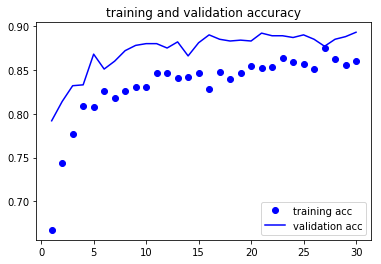

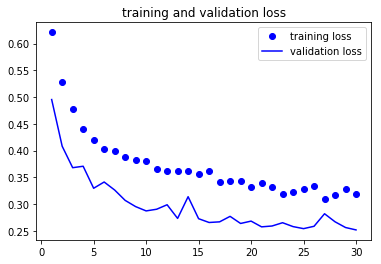

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [18]:
val_loss, val_acc = network.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", round(val_acc*100,2), "%")

Validation loss: 0.24749683901667596
Validation accuracy: 89.5 %
